## 1. Necessary library imports
Following are the libraries we will be using

In [1]:
import os
import random
import json
import csv
from tqdm.notebook import tqdm as tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import pickle
import pytz
from datetime import datetime

from gensim import models
import gensim.downloader

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob
from textblob.parsers import PatternParser

from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Mounting Google Drive Data Storage

In [2]:
from google.colab import drive
drive.mount('/content\/gdrive')

Mounted at /content/gdrive


## Load w2v models from gdrive





In [3]:
w2v_google = models.KeyedVectors.load_word2vec_format('./gdrive/MyDrive/w2v_vectors/GoogleNews-vectors-negative300.bin', binary=True)

## 3. Loading Dataset 
1. We will use python csv reader to load the file
1. Then store the raw text to `X` and labels to `y`

Datasets Used:
1. Onion or Not Dataset
1. Fake News Dataset [link](https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php)

### 3.1 Merging the datasets into one np array file format

In [4]:
X = []
y = []

In [5]:
with open('./gdrive/MyDrive/datasets/fake_news_dataset/Fake.csv') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    headers = csv_reader.fieldnames
    for row in csv_reader:
        X.append(row['title'])
        y.append('2')

with open('./gdrive/MyDrive/datasets/fake_news_dataset/True.csv') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    headers = csv_reader.fieldnames
    for row in csv_reader:
        X.append(row['title'])
        y.append('0')

In [6]:
with open('./gdrive/MyDrive/datasets/OnionOrNot.csv') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    headers = csv_reader.fieldnames
    for row in csv_reader:
        X.append(row['text'])
        y.append(row['label'])

In [7]:
#text and labels are now in NP ND array data structure
X = np.array(X)
y = np.array(y)

In [8]:
#Assuring that the length of both train and labels are equal
print(len(X))
print(len(y))

68898
68898


In [9]:
# count the size of each class
Counter(y)

Counter({'0': 36417, '1': 9000, '2': 23481})

### 3.1.1 Restrict data size for equality and saving

In [ ]:
combinedArray = np.array(list(zip(X, y)))
class0 = combinedArray[combinedArray[:, 1] == '0']
class1 = combinedArray[combinedArray[:, 1] == '1']
class2 = combinedArray[combinedArray[:, 1] == '2']

np.random.seed(0)
np.random.shuffle(class0)
class0shuf = class0[:9000]
class0shuf.shape

np.random.seed(0)
np.random.shuffle(class1)
class1shuf = class1[:9000]
class1shuf.shape

np.random.seed(0)
np.random.shuffle(class2)
class2shuf = class2[:9000]
class2shuf.shape

(9000, 2)

### 3.2 Saving the transformed np array dataset file

In [ ]:
try:
    with open('./gdrive/MyDrive/datasets/merged_dataset_X.npy', 'wb') as f:
        np.save(f, X)
    with open('./gdrive/MyDrive/datasets/merged_dataset_y.npy', 'wb') as f:
        np.save(f, y)
    print('files successfully saved!')
except IOError:
    print("cannot write to the file!")

files successfully saved!


### 3.3 Loading the file back to X and y
*Note: if the merged dataset file already exists, you can skip section 3.1*

In [10]:
try:
    with open('./gdrive/MyDrive/datasets/merged_dataset_X.npy', 'rb') as f:
        X = np.load(f)
    with open('./gdrive/MyDrive/datasets/merged_dataset_y.npy', 'rb') as f:
        y = np.load(f)
except IOError:
    print('file load failed!')

In [11]:
N = len(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"train X: {len(X_train)} train y: {len(y_train)}")
print(f"test X: {len(X_test)} test y: {len(y_test)}")

train X: 55118 train y: 55118
test X: 13780 test y: 13780


## Defining the training pipeline using Scikit-Learn Pipeline

In [12]:
def train_model(clf, X_train, y_train):
    vectorizer = CountVectorizer(analyzer='word', token_pattern=r"\b[0-9a-zA-Z]+\b", ngram_range=(1,2))
    tfidf_transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True)
    # TODO: tfidf_transformer > word2vec
    model = Pipeline([('vectorizer', vectorizer),
                    ('tfidf_transformer', tfidf_transformer),
                    ('classifier', clf)])
    model = model.fit(X_train, y_train)
    return model

In [13]:
def predict(model, X_test):
    return model.predict(X_test)

## Evaluation Using Confusion Matrix
1. Using only two labels (onion, not-onion)

Reference Taken from Scikit-Learn documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [14]:
def evaluate_model_mistakes(model, X_train, y_train, X_test, y_test, model_str):
    y_pred = predict(model, X_train)
    train_score = f1_score(y_train, y_pred, average='macro')
    print('train score on validation = {}'.format(train_score))

    y_pred_test = predict(model, X_test)
    score_test = f1_score(y_test, y_pred_test, average='macro')
    print('score on test-dataset = {}'.format(score_test))

    # find examples that are onion mistaken as fake
    mistakes = []
    for i in range(len(X_test)):
        if(y_pred[i] == '2' and y_test[i] == '1'):
            mistakes.append(X_test[i])
    return round(score_test,2), mistakes

In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_str):
    y_pred = predict(model, X_train)
    train_score = f1_score(y_train, y_pred, average='macro')
    print('train score on validation = {}'.format(train_score))

    y_pred_test = predict(model, X_test)
    score_test = f1_score(y_test, y_pred_test, average='macro')
    print('score on test-dataset = {}'.format(score_test))

    return round(score_test,2)

In [16]:
def plot_confusion_matrix_(model_str, model, X_test, y_test, save=True):
    # Plot non-normalized confusion matrix
    class_names = ['real', 'onion', 'fake']
    titles_options = [(f"{model_str} - Confusion_matrix_without_normalization", None),
                    (f"{model_str} - Normalized_confusion_matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                    display_labels=class_names,
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        if save:
            plt.savefig(f'./gdrive/MyDrive/{title}.png')
        
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    plt.show()


In [17]:
def save_model(filename, classifier):
    pkl_filename = f"./gdrive/MyDrive/{filename}.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

Beginning training for Logistic Regression w2v...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s finished


train score on validation = 0.8988869281178018
score on test-dataset = 0.8919081087703652
Logistic Regression w2v - Normalized_confusion_matrix
[[0.95606351 0.0261429  0.01779359]
 [0.08148948 0.78791149 0.13059903]
 [0.02769963 0.04068383 0.93161653]]


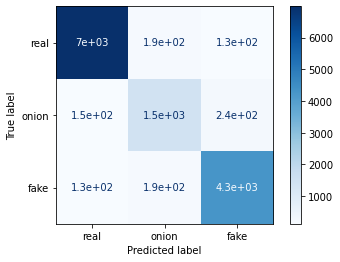

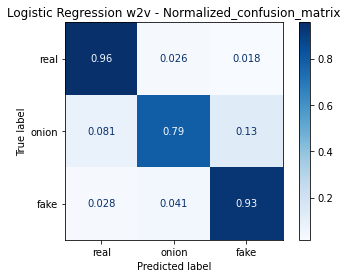

['Panicked Oyster Praying That Lump It Feels Forming Only A Pearl', 'New Uber Update Allows Users To File Lawsuit Against Company Directly In App', 'Caitlyn Jenner Once More Bravely Stands Up For Trans People With Unlimited Resources', 'Trump Announces Paris Climate Deal Rejection In Front Of 16 Running Faucets', 'Kobe Bryant Claims He Would’ve Won 12 Rings If Shaq’s Deadbeat Father Was Around To Instill Stronger Work Ethic', 'LeBron James To Star In ‘Space Jam’ Sequel', 'News: Just Like Us: This Chimpanzee Shot Himself In The Head After The IRS Uncovered His Tax Fraud Scheme', 'Number Of Users Who Actually Enjoy Facebook Down To 4 | The Onion', 'News: Education FTW: ‘Sesame Street’ Showed Grover Laying An Egg That Elmo And Ernie Both Hatch Out Of To Teach Children Not Everything Can Be Explained With A Catchy Little Song', 'Lindsey Graham Struggling To Stay Awake While Driving Empty Campaign Bus Overnight To Next Event', 'Psychologists Say It Perfectly Natural To Fantasize About Sandw

In [22]:


logreg_classifier = LogisticRegression(verbose=1, solver='lbfgs', C=3.8, penalty='l2', max_iter=1500)
svc = SVC(kernel='linear', gamma='auto')
nb_classifier = MultinomialNB()
classifiers = {
    'Logistic Regression w2v': logreg_classifier,
    # 'Multinomial Naive Bayes w2v': nb_classifier,
    # 'Support Vector Machine w2v': svc
}

for model_name, classifier in tqdm(classifiers.items()):
    print(f"Beginning training for {model_name}...")
    # model = train_model(classifier, X_train, y_train)
    model = train_model_w2v(classifier, X_train, y_train)
    score_test, mistakes= evaluate_model_mistakes(model, X_train, y_train, X_test, y_test, model_name)
    plot_confusion_matrix_(model_name, model, X_test, y_test)
    
    # tz = pytz.timezone('Asia/Singapore')
    # time_now = datetime.now(tz) #time now
    # dt = time_now.strftime("%m-%d-%Y-%H-%M-%S")# local time
    # save_model(f"{model_name}_acc[{score_test}]_{dt}", classifier)
    print(mistakes)



## Plot Classification Probability
Using Reference: https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html#sphx-glr-auto-examples-classification-plot-classification-probability-py

## Word2Vec Feature Extraction
trying with different feature extraction method
* word2vec

word2vec Reference [here](https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm)

Sarcasm Detection Notebook Reference [here](https://www.kaggle.com/vrishabhps/sarcasm-detection-using-keras-and-nltk)

### Defining a custom transformer for word2vec

In [19]:
class Word2VecMeanTransformer(object):
    def __init__(self, model):
        self.w2v = model
        # word2vec-google-news-300
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = self.w2v.vector_size
        self.word2weight = None


    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: word_tokenize(x))
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        # no additional fitting of word2vec model
        return self
    
    def transform(self, X):
        # X is a sentence, so we have to tokenize it
        result = np.array([
                         np.mean([self.w2v[w] for w in word_tokenize(words) if w in self.w2v]
                                 or [np.zeros(self.dim)], axis = 0)
                         for words in X
        ])
        return result

### Build new pipeline for word2vec


In [20]:
def train_model_w2v(clf, X_train, Y_train):
    w2vTransformer = Word2VecMeanTransformer(w2v_google)
    model = Pipeline([('w2v', w2vTransformer),
                    ('classifier', clf)])
    model = model.fit(X_train, y_train)
    return model

### Store word2vec vectors

In [ ]:
for X in [[X_train, "X_train"], [X_test, "X_test"]]:
    
    result = np.array([
        np.mean([w2v_google[w] for w in word_tokenize(headline) if w in w2v_google]
                or [np.zeros(300)], axis = 0)
        for headline in X[0]
    ])
    print(len(result))
    print(X[0][0])
    print(X_train[0])
    print(X_test[0])
    # print(result[1])
    with open(f"./gdrive/MyDrive/datasets/word2vec{X[1]}.pkl", 'wb') as pickle_file:
        pickle.dump(result, pickle_file)

55118
Rich, White, Healthy People Are Most Likely to Hate Obamacare
Rich, White, Healthy People Are Most Likely to Hate Obamacare
Trump says unnamed country plans to build, expand five U.S. auto plants
13780
Trump says unnamed country plans to build, expand five U.S. auto plants
Rich, White, Healthy People Are Most Likely to Hate Obamacare
Trump says unnamed country plans to build, expand five U.S. auto plants


# New approaches to consider:

## Rule-based approaches
### parsing-based lexicon generation algorithm

## Statistical approaches

## Deep Learning-based approaches


#Parsing-based lexicon generation algorithm (PBLGA)

credits to: https://github.com/rkp768/Sarcasm_Detction_Algos/blob/master/pblga.py, Parsing-based Sarcasm Sentiment Recognition in
Twitter Data 

PBLGA identifies sentiment and situation from headlines through POS tagging and sentiment analysis (from the `textblob` library). Sarcasm is identified when there is a mismatch between sentiment and situation (positive sentiment, negative situation phrase).


In [ ]:
def check_sarc(tweet):
    blob = TextBlob(tweet, parser=PatternParser())
    tokens = blob.parse().split(' ')
    dic = defaultdict(list)  # stores all phrases by category
    temp = ''
    phrases = []  # list of all phrases
    print(tokens)
    for t in tokens:
        if t.split('/')[2] == 'O':
            if temp:
                phrases.append((ctag, temp))
            dic[t.split('/')[2]].append(temp)
            temp = t.split('/')[0]+' '
            ctag = t.split('/')[2]
        elif 'B-' in t.split('/')[2]:
            if temp:
                phrases.append((ctag, temp))
            temp = t.split('/')[0]+' '
            dic[t.split('/')[2].split('-')[1]].append(temp)
            ctag = t.split('/')[2].split('-')[1]
        elif 'I-' in t.split('/')[2]:
            dic[t.split('/')[2].split('-')[1]][-1] += t.split('/')[0]+' '
            temp += t.split('/')[0]+' '
            ctag = t.split('/')[2].split('-')[1]
        else:
            pass
    if temp:
        phrases.append((ctag, temp))
    SF = []
    sf = []
    for i in phrases:
        if i[0] in ['NP', 'ADjP']:
            SF.append(i[1])
        elif i[0] == 'VP':
            sf.append(i[1])
    for i in range(len(phrases)-1):
        if phrases[i][0] == 'NP' and phrases[i+1][0] == 'VP':
            SF.append(phrases[i][1]+' '+phrases[i+1][1])
        elif phrases[i][0] == 'ADVP' and phrases[i+1][0] == 'VP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1])
        elif phrases[i][0] == 'VP' and phrases[i+1][0] == 'ADVP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1])
        elif phrases[i][0] == 'ADJP' and phrases[i+1][0] == 'VP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1])
        elif phrases[i][0] == 'VP' and phrases[i+1][0] == 'NP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1])
    for i in range(len(phrases)-2):
        if phrases[i][0] == 'VP' and phrases[i+1][0] == 'ADVP' and phrases[i+2][0] == 'ADJP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1]+' '+phrases[i+1][1])
        elif phrases[i][0] == 'VP' and phrases[i+1][0] == 'ADJP' and phrases[i+2][0] == 'NP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1]+' '+phrases[i+2][1])
        elif phrases[i][0] == 'ADVP' and phrases[i+1][0] == 'ADJP' and phrases[i+2][0] == 'NP':
            sf.append(phrases[i][1]+' '+phrases[i+1][1]+' '+phrases[i+2][1])
    print(SF)
    print(sf)
    PSF = []
    NSF = []
    psf = []
    nsf = []
    for i in SF:
        blob = TextBlob(i)
        if blob.polarity > 0:
            PSF.append(i)
        elif blob.polarity < 0:
            NSF.append(i)
        elif blob.polarity == 0:
            pass
    for i in sf:
        blob = TextBlob(i)
        if blob.polarity > 0:
            psf.append(i)
        elif blob.polarity < 0:
            psf.append(i)
        elif blob.polarity == 0:
            pass
    print(PSF)
    print(NSF)
    print(psf)
    print(nsf)
    if (PSF and nsf) or (psf and NSF):
        return 1
    else:
        return 0
	

In [ ]:
print(check_sarc("I'm glad we're having a rehearsal dinner. I rarely practice my meals before I eat."))

['I/PRP/B-NP/O', "'/POS/O/O", 'm/NN/B-NP/O', 'glad/JJ/I-NP/O', 'we/PRP/I-NP/O', "'/POS/O/O", 're/NN/B-NP/O', 'having/VBG/B-VP/O', 'a/DT/B-NP/O', 'rehearsal/NN/I-NP/O', 'dinner/NN/I-NP/O', '././O/O\nI/PRP/B-NP/O', 'rarely/RB/I-NP/O', 'practice/NN/I-NP/O', 'my/PRP$/I-NP/O', 'meals/NNS/I-NP/O', 'before/IN/B-PP/B-PNP', 'I/PRP/B-NP/I-PNP', 'eat/VB/B-VP/O', '././O/O']
['I ', 'm glad we ', 're ', 'a rehearsal dinner ', '. rarely practice my meals ', 'I ', 're  having ', 'I  eat ']
['having ', 'eat ', 'having  a rehearsal dinner ']
['m glad we ', '. rarely practice my meals ']
[]
[]
[]
0


#